<a href="https://colab.research.google.com/github/shreyadas-maple/BIL_Project_work/blob/main/Build_XGBoost_AB_NO_SMOTE_(Classification)_F_195_Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Optuna for hyperparameter optimization of the models that we might want to train

%pip install optuna

In [ ]:

import os
import numpy as np
import pandas as pd
from typing import List, Optional

from google.auth import default

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import optuna
import shap
import matplotlib.pyplot as plt

# Optional: nicer printing
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)



In [ ]:
# 2) Read-in the csv for the dataset
df = pd.read_csv("./ADNI_PET_AB_EPVS_DTI_ALPS_T1_aparc_aseg_ravens_contrast_EXTRA_TIV_Norm_FW.csv")

# If we want to filter out the tracers from the dataset
FILTER_TRACER = None

SEED = 13

df.shape

# Z-Score or StandardScaler could improve the accuracy
# save the mean and SD for reporting -> both must be the same between testing and training

(394, 584)

In [ ]:
features_df = pd.read_csv("./F_195.csv")
display(features_df.head())

,CENTILOIDS_AB_tx,AGE_Actual,PTGENDER,lh_bankssts_volume,lh_caudalanteriorcingulate_volume,lh_caudalmiddlefrontal_volume,lh_cuneus_volume,lh_entorhinal_volume,lh_fusiform_volume,lh_inferiorparietal_volume,lh_inferiortemporal_volume,lh_isthmuscingulate_volume,lh_lateraloccipital_volume,lh_lateralorbitofrontal_volume,lh_lingual_volume,lh_medialorbitofrontal_volume,lh_middletemporal_volume,lh_parahippocampal_volume,lh_paracentral_volume,lh_parsopercularis_volume,lh_parsorbitalis_volume,lh_parstriangularis_volume,lh_pericalcarine_volume,lh_postcentral_volume,lh_posteriorcingulate_volume,lh_precentral_volume,lh_precuneus_volume,lh_rostralanteriorcingulate_volume,lh_rostralmiddlefrontal_volume,lh_superiorfrontal_volume,lh_superiorparietal_volume,lh_superiortemporal_volume,lh_supramarginal_volume,lh_frontalpole_volume,lh_temporalpole_volume,lh_transversetemporal_volume,lh_insula_volume,rh_bankssts_volume,rh_caudalanteriorcingulate_volume,rh_caudalmiddlefrontal_volume,rh_cuneus_volume,rh_entorhinal_volume,rh_fusiform_volume,rh_inferiorparietal_volume,rh_inferiortemporal_volume,rh_isthmuscingulate_volume,rh_lateraloccipital_volume,rh_lateralorbitofrontal_volume,rh_lingual_volume,rh_medialorbitofrontal_volume,rh_middletemporal_volume,rh_parahippocampal_volume,rh_paracentral_volume,rh_parsopercularis_volume,rh_parsorbitalis_volume,rh_parstriangularis_volume,rh_pericalcarine_volume,rh_postcentral_volume,rh_posteriorcingulate_volume,rh_precentral_volume,rh_precuneus_volume,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,Left.Lateral.Ventricle,Left.Inf.Lat.Vent,Left.Cerebellum.White.Matter,Left.Cerebellum.Cortex,Left.Thalamus,Left.Caudate,Left.Putamen,Left.Pallidum,X3rd.Ventricle,X4th.Ventricle,Brain.Stem,Left.Hippocampus,Left.Amygdala,Left.Accumbens.area,Left.choroid.plexus,Right.Lateral.Ventricle,Right.Inf.Lat.Vent,Right.Cerebellum.White.Matter,Right.Cerebellum.Cortex,Right.Thalamus,Right.Caudate,Right.Putamen,Right.Pallidum,Right.Hippocampus,Right.Amygdala,Right.Accumbens.area,Right.choroid.plexus,CC_Posterior,CC_Mid_Posterior,CC_Central,CC_Mid_Anterior,CC_Anterior,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,lh_lateralorbitofrontal_thickness,lh_lingual_thickness,lh_medialorbitofrontal_thickness,lh_middletemporal_thickness,lh_parahippocampal_thickness,lh_paracentral_thickness,lh_parsopercularis_thickness,lh_parsorbitalis_thickness,lh_parstriangularis_thickness,lh_pericalcarine_thickness,lh_postcentral_thickness,lh_posteriorcingulate_thickness,lh_precentral_thickness,lh_precuneus_thickness,lh_rostralanteriorcingulate_thickness,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,rh_bankssts_thickness,rh_caudalanteriorcingulate_thickness,rh_caudalmiddlefrontal_thickness,rh_cuneus_thickness,rh_entorhinal_thickness,rh_fusiform_thickness,rh_inferiorparietal_thickness,rh_inferiortemporal_thickness,rh_isthmuscingulate_thickness,rh_lateraloccipital_thickness,rh_lateralorbitofrontal_thickness,rh_lingual_thickness,rh_medialorbitofrontal_thickness,rh_middletemporal_thickness,rh_parahippocampal_thickness,rh_paracentral_thickness,rh_parsopercularis_thickness,rh_parsorbitalis_thickness,rh_parstriangularis_thickness,rh_pericalcarine_thickness,rh_postcentral_thickness,rh_posteriorcingulate_thickness,rh

In [ ]:
features_df.shape

(0, 183)

In [ ]:
# Load the feature names from the CSV file
feature_names = pd.read_csv("./F_195.csv", header=None).iloc[0].tolist()

# Select the features from the main DataFrame
df_features_selected = df[feature_names]

display(df_features_selected.head())

,CENTILOIDS_AB_tx,AGE_Actual,PTGENDER,lh_bankssts_volume,lh_caudalanteriorcingulate_volume,lh_caudalmiddlefrontal_volume,lh_cuneus_volume,lh_entorhinal_volume,lh_fusiform_volume,lh_inferiorparietal_volume,lh_inferiortemporal_volume,lh_isthmuscingulate_volume,lh_lateraloccipital_volume,lh_lateralorbitofrontal_volume,lh_lingual_volume,lh_medialorbitofrontal_volume,lh_middletemporal_volume,lh_parahippocampal_volume,lh_paracentral_volume,lh_parsopercularis_volume,lh_parsorbitalis_volume,lh_parstriangularis_volume,lh_pericalcarine_volume,lh_postcentral_volume,lh_posteriorcingulate_volume,lh_precentral_volume,lh_precuneus_volume,lh_rostralanteriorcingulate_volume,lh_rostralmiddlefrontal_volume,lh_superiorfrontal_volume,lh_superiorparietal_volume,lh_superiortemporal_volume,lh_supramarginal_volume,lh_frontalpole_volume,lh_temporalpole_volume,lh_transversetemporal_volume,lh_insula_volume,rh_bankssts_volume,rh_caudalanteriorcingulate_volume,rh_caudalmiddlefrontal_volume,rh_cuneus_volume,rh_entorhinal_volume,rh_fusiform_volume,rh_inferiorparietal_volume,rh_inferiortemporal_volume,rh_isthmuscingulate_volume,rh_lateraloccipital_volume,rh_lateralorbitofrontal_volume,rh_lingual_volume,rh_medialorbitofrontal_volume,rh_middletemporal_volume,rh_parahippocampal_volume,rh_paracentral_volume,rh_parsopercularis_volume,rh_parsorbitalis_volume,rh_parstriangularis_volume,rh_pericalcarine_volume,rh_postcentral_volume,rh_posteriorcingulate_volume,rh_precentral_volume,rh_precuneus_volume,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,Left.Lateral.Ventricle,Left.Inf.Lat.Vent,Left.Cerebellum.White.Matter,Left.Cerebellum.Cortex,Left.Thalamus,Left.Caudate,Left.Putamen,Left.Pallidum,X3rd.Ventricle,X4th.Ventricle,Brain.Stem,Left.Hippocampus,Left.Amygdala,Left.Accumbens.area,Left.choroid.plexus,Right.Lateral.Ventricle,Right.Inf.Lat.Vent,Right.Cerebellum.White.Matter,Right.Cerebellum.Cortex,Right.Thalamus,Right.Caudate,Right.Putamen,Right.Pallidum,Right.Hippocampus,Right.Amygdala,Right.Accumbens.area,Right.choroid.plexus,CC_Posterior,CC_Mid_Posterior,CC_Central,CC_Mid_Anterior,CC_Anterior,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,lh_lateralorbitofrontal_thickness,lh_lingual_thickness,lh_medialorbitofrontal_thickness,lh_middletemporal_thickness,lh_parahippocampal_thickness,lh_paracentral_thickness,lh_parsopercularis_thickness,lh_parsorbitalis_thickness,lh_parstriangularis_thickness,lh_pericalcarine_thickness,lh_postcentral_thickness,lh_posteriorcingulate_thickness,lh_precentral_thickness,lh_precuneus_thickness,lh_rostralanteriorcingulate_thickness,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,rh_bankssts_thickness,rh_caudalanteriorcingulate_thickness,rh_caudalmiddlefrontal_thickness,rh_cuneus_thickness,rh_entorhinal_thickness,rh_fusiform_thickness,rh_inferiorparietal_thickness,rh_inferiortemporal_thickness,rh_isthmuscingulate_thickness,rh_lateraloccipital_thickness,rh_lateralorbitofrontal_thickness,rh_lingual_thickness,rh_medialorbitofrontal_thickness,rh_middletemporal_thickness,rh_parahippocampal_thickness,rh_paracentral_thickness,rh_parsopercularis_thickness,rh_parsorbitalis_thickness,rh_parstriangularis_thickness,rh_pericalcarine_thickness,rh_postcentral_thickness,rh_posteriorcingulate_thickness,rh

In [ ]:
df['CENTILOIDS_AB_tx_encoded'] = (df['CENTILOIDS_AB_tx'] >= 37).astype(int)
display(df[['CENTILOIDS_AB_tx', 'CENTILOIDS_AB_tx_encoded']].head())

,CENTILOIDS_AB_tx,CENTILOIDS_AB_tx_encoded
0,-22,0
1,-9,0
2,11,0
3,34,0
4,-4,0


In [ ]:
# Load the feature names from the CSV file
feature_names = pd.read_csv("./F_195.csv", header=None).iloc[0].tolist()

# Select the features from the main DataFrame
df_selected_features = df[feature_names]

# Separate features (X) and target (y)
X = df_selected_features.drop(columns=['CENTILOIDS_AB_tx']) # Drop the original, not the encoded column
y = df['CENTILOIDS_AB_tx_encoded']

display(X.head())
display(y.head())

,AGE_Actual,PTGENDER,lh_bankssts_volume,lh_caudalanteriorcingulate_volume,lh_caudalmiddlefrontal_volume,lh_cuneus_volume,lh_entorhinal_volume,lh_fusiform_volume,lh_inferiorparietal_volume,lh_inferiortemporal_volume,lh_isthmuscingulate_volume,lh_lateraloccipital_volume,lh_lateralorbitofrontal_volume,lh_lingual_volume,lh_medialorbitofrontal_volume,lh_middletemporal_volume,lh_parahippocampal_volume,lh_paracentral_volume,lh_parsopercularis_volume,lh_parsorbitalis_volume,lh_parstriangularis_volume,lh_pericalcarine_volume,lh_postcentral_volume,lh_posteriorcingulate_volume,lh_precentral_volume,lh_precuneus_volume,lh_rostralanteriorcingulate_volume,lh_rostralmiddlefrontal_volume,lh_superiorfrontal_volume,lh_superiorparietal_volume,lh_superiortemporal_volume,lh_supramarginal_volume,lh_frontalpole_volume,lh_temporalpole_volume,lh_transversetemporal_volume,lh_insula_volume,rh_bankssts_volume,rh_caudalanteriorcingulate_volume,rh_caudalmiddlefrontal_volume,rh_cuneus_volume,rh_entorhinal_volume,rh_fusiform_volume,rh_inferiorparietal_volume,rh_inferiortemporal_volume,rh_isthmuscingulate_volume,rh_lateraloccipital_volume,rh_lateralorbitofrontal_volume,rh_lingual_volume,rh_medialorbitofrontal_volume,rh_middletemporal_volume,rh_parahippocampal_volume,rh_paracentral_volume,rh_parsopercularis_volume,rh_parsorbitalis_volume,rh_parstriangularis_volume,rh_pericalcarine_volume,rh_postcentral_volume,rh_posteriorcingulate_volume,rh_precentral_volume,rh_precuneus_volume,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,Left.Lateral.Ventricle,Left.Inf.Lat.Vent,Left.Cerebellum.White.Matter,Left.Cerebellum.Cortex,Left.Thalamus,Left.Caudate,Left.Putamen,Left.Pallidum,X3rd.Ventricle,X4th.Ventricle,Brain.Stem,Left.Hippocampus,Left.Amygdala,Left.Accumbens.area,Left.choroid.plexus,Right.Lateral.Ventricle,Right.Inf.Lat.Vent,Right.Cerebellum.White.Matter,Right.Cerebellum.Cortex,Right.Thalamus,Right.Caudate,Right.Putamen,Right.Pallidum,Right.Hippocampus,Right.Amygdala,Right.Accumbens.area,Right.choroid.plexus,CC_Posterior,CC_Mid_Posterior,CC_Central,CC_Mid_Anterior,CC_Anterior,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,lh_lateralorbitofrontal_thickness,lh_lingual_thickness,lh_medialorbitofrontal_thickness,lh_middletemporal_thickness,lh_parahippocampal_thickness,lh_paracentral_thickness,lh_parsopercularis_thickness,lh_parsorbitalis_thickness,lh_parstriangularis_thickness,lh_pericalcarine_thickness,lh_postcentral_thickness,lh_posteriorcingulate_thickness,lh_precentral_thickness,lh_precuneus_thickness,lh_rostralanteriorcingulate_thickness,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,rh_bankssts_thickness,rh_caudalanteriorcingulate_thickness,rh_caudalmiddlefrontal_thickness,rh_cuneus_thickness,rh_entorhinal_thickness,rh_fusiform_thickness,rh_inferiorparietal_thickness,rh_inferiortemporal_thickness,rh_isthmuscingulate_thickness,rh_lateraloccipital_thickness,rh_lateralorbitofrontal_thickness,rh_lingual_thickness,rh_medialorbitofrontal_thickness,rh_middletemporal_thickness,rh_parahippocampal_thickness,rh_paracentral_thickness,rh_parsopercularis_thickness,rh_parsorbitalis_thickness,rh_parstriangularis_thickness,rh_pericalcarine_thickness,rh_postcentral_thickness,rh_posteriorcingulate_thickness,rh_precentral_thick

,CENTILOIDS_AB_tx_encoded
0,0
1,0
2,0
3,0
4,0


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (315, 182) (315,)
Testing set shape: (79, 182) (79,)


In [ ]:
!pip install lazypredict

from lazypredict.Supervised import LazyClassifier

# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and evaluate models
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Display the results
display(models)

# Save the models summary to a CSV file
models.to_csv("lazy_classifier_models_summary.csv")

print("\nModels summary saved to 'lazy_classifier_models_summary.csv'")

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 136, number of negative: 179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19188
[LightGBM] [Info] Number of data points in the train set: 315, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431746 -> initscore=-0.274731
[LightGBM] [Info] Start training from score -0.274731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.68,0.67,0.67,0.68,0.04
AdaBoostClassifier,0.66,0.64,0.64,0.65,0.77
LogisticRegression,0.66,0.63,0.63,0.64,0.05
LGBMClassifier,0.65,0.62,0.62,0.64,0.40
Perceptron,0.63,0.61,0.61,0.63,0.02
NuSVC,0.63,0.61,0.61,0.62,0.06
GaussianNB,0.62,0.61,0.61,0.62,0.04
SVC,0.63,0.60,0.60,0.61,0.06
PassiveAggressiveClassifier,0.62,0.59,0.59,0.61,0.05



Models summary saved to 'lazy_classifier_models_summary.csv'


# Task
Tune the hyperparameters of an XGBoost classifier using Optuna and 10-fold cross-validation, train the model on the training data, and evaluate its performance on the test data.

## Define the objective function for optuna

### Subtask:
Create a function that takes an Optuna trial object as input, builds and trains an XGBoost model with hyperparameters suggested by the trial, performs 10-fold cross-validation, and returns the average ROC AUC score.


**Reasoning**:
Define the objective function for Optuna to tune the XGBoost hyperparameters using 10-fold cross-validation and ROC AUC as the evaluation metric.



In [ ]:
def objective(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.

    Args:
        trial: An Optuna trial object.

    Returns:
        The average ROC AUC score from 10-fold cross-validation.
    """
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'random_state': SEED,
        'use_label_encoder': False,
        'eval_metric': 'auc'
    }

    # Create XGBoost classifier instance
    model = xgb.XGBClassifier(**params)

    # Implement 10-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    # Perform cross-validation and get ROC AUC scores
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')

    # Calculate the mean of the cross-validation scores
    mean_roc_auc = scores.mean()

    return mean_roc_auc

## Run optuna optimization

### Subtask:
Create an Optuna study and run the optimization process using the defined objective function to find the best hyperparameters.


**Reasoning**:
Create an Optuna study, run the optimization, and print the best results.



In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import json

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Run the optimization process
study.optimize(objective, n_trials=50)

# Print the best trial's value
print(f"Best ROC AUC: {study.best_trial.value}")

# Print the best trial's hyperparameters
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Save the best hyperparameters to a JSON file
with open('best_xgboost_params.json', 'w') as f:
    json.dump(study.best_params, f)

print("\nBest hyperparameters saved to 'best_xgboost_params.json'")

[I 2025-10-16 19:23:23,912] A new study created in memory with name: no-name-cfc471c4-e180-4fd9-b994-8117eecabbfa
[I 2025-10-16 19:23:53,773] Trial 0 finished with value: 0.7307297277885514 and parameters: {'n_estimators': 313, 'max_depth': 5, 'learning_rate': 0.04898277323737222, 'subsample': 0.6690405272293757, 'colsample_bytree': 0.626060094140864, 'gamma': 0.41680005094544015}. Best is trial 0 with value: 0.7307297277885514.
[I 2025-10-16 19:25:14,483] Trial 1 finished with value: 0.744451626804568 and parameters: {'n_estimators': 858, 'max_depth': 8, 'learning_rate': 0.025671992070960437, 'subsample': 0.83059054785206, 'colsample_bytree': 0.6528924275399616, 'gamma': 0.09122279333763161}. Best is trial 1 with value: 0.744451626804568.
[I 2025-10-16 19:25:41,024] Trial 2 finished with value: 0.7172933275874452 and parameters: {'n_estimators': 798, 'max_depth': 4, 'learning_rate': 0.18487791384486063, 'subsample': 0.6906640386426749, 'colsample_bytree': 0.8297180234892509, 'gamma': 

Best ROC AUC: 0.7644975939093586
Best hyperparameters:
  n_estimators: 106
  max_depth: 6
  learning_rate: 0.027484493693285067
  subsample: 0.9334854477827621
  colsample_bytree: 0.8486471257193842
  gamma: 0.41818416779310774

Best hyperparameters saved to 'best_xgboost_params.json'


In [ ]:
import json
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd

# Load the best hyperparameters from the JSON file
with open('best_xgboost_params.json', 'r') as f:
    best_params = json.load(f)

# Build the XGBoost model with the best hyperparameters
optimized_model = xgb.XGBClassifier(**best_params, random_state=SEED, use_label_encoder=False, eval_metric='auc')

# Train the model on the training data
optimized_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = optimized_model.predict(X_test)
y_proba = optimized_model.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_proba)
report_dict = classification_report(y_test, y_pred, output_dict=True)

print(f"ROC AUC on the test set: {roc_auc}")
print("Classification Report on the test set:")
print(classification_report(y_test, y_pred))

# Create a dictionary for the evaluation metrics
eval_metrics = {
    'Metric': ['ROC AUC', 'Accuracy', 'Precision (Class 0)', 'Recall (Class 0)', 'F1-Score (Class 0)',
               'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)'],
    'Score': [roc_auc, report_dict['accuracy'], report_dict['0']['precision'], report_dict['0']['recall'],
              report_dict['0']['f1-score'], report_dict['1']['precision'], report_dict['1']['recall'],
              report_dict['1']['f1-score']]
}

# Convert the dictionary to a pandas DataFrame
eval_metrics_df = pd.DataFrame(eval_metrics)

# Display the evaluation metrics table
display(eval_metrics_df)

# Save the evaluation metrics table to a CSV file
eval_metrics_df.to_csv("optimized_model_evaluation_metrics.csv", index=False)

print("\nEvaluation metrics saved to 'optimized_model_evaluation_metrics.csv'")

ROC AUC on the test set: 0.6620915032679738
Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.62      0.67      0.65        45
           1       0.52      0.47      0.49        34

    accuracy                           0.58        79
   macro avg       0.57      0.57      0.57        79
weighted avg       0.58      0.58      0.58        79



,Metric,Score
0,ROC AUC,0.66
1,Accuracy,0.58
2,Precision (Class 0),0.62
3,Recall (Class 0),0.67
4,F1-Score (Class 0),0.65
5,Precision (Class 1),0.52
6,Recall (Class 1),0.47
7,F1-Score (Class 1),0.49



Evaluation metrics saved to 'optimized_model_evaluation_metrics.csv'


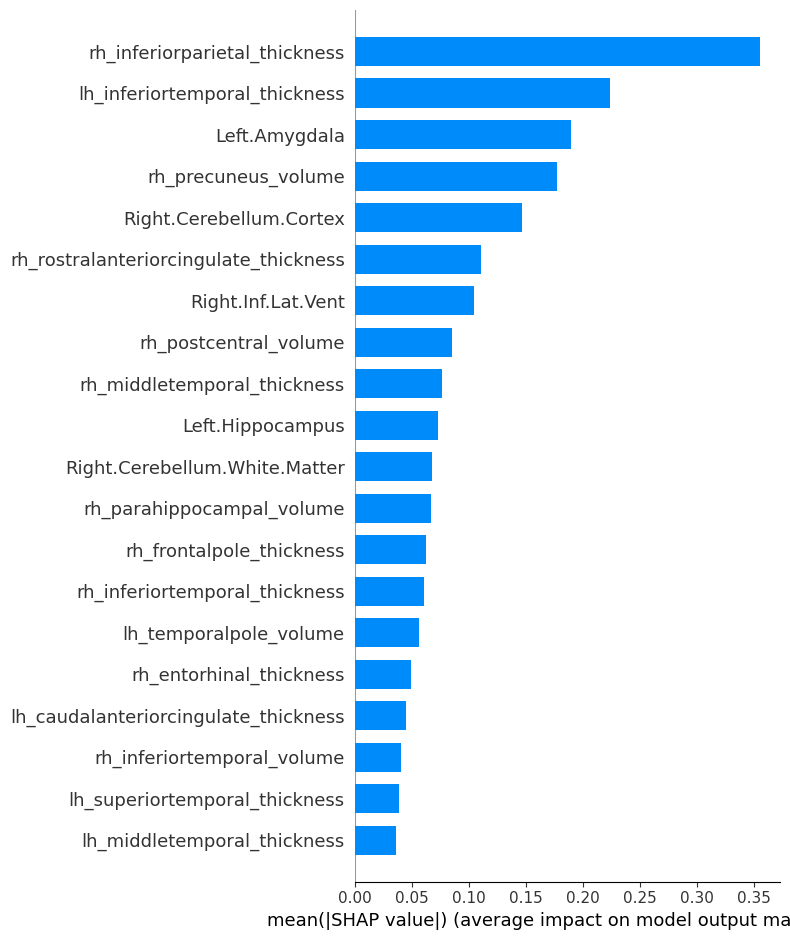

In [ ]:
# Use SHAP to figure out which features contribute most to the classification
explainer = shap.TreeExplainer(optimized_model)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig("shap_summary_plot.png", bbox_inches='tight')
plt.show()